<a href="https://colab.research.google.com/github/MazinOnsa/CNN/blob/master/Train_Caltech_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                 بسم الله الرحمن الرحيم




---


*In God we trust, all others should bring Data*
# Training Caltech 101 on AlexNet




**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

     |████████████████████████████████| 734.6MB 22kB/s 
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
     |████████████████████████████████| 4.0MB 4.7MB/s 
     |████████████████████████████████| 753.4MB 10kB/s 
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
     |████████████████████████████████| 634kB 4.9MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-7.0.0.post3-cp36-cp36m-linux_x86_64.whl size=1110225 sha256=ce70bfa45f3afa98917ff566c5929698f9facd5cd4c711176c145978c2a8050e
  Stored in directory: /root/.cache/pip/wheels/d3/ac/4f/4cdf8febba528e5f1b09fc58d5181

**Import libraries**

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
#i can use DataLoader without above import directly
#trainloader=torch.utils.data.Dataloader(train,batch...) 
from torch.backends import cudnn

import torchvision
from torchvision import transforms # transform images to pytoch tensors
from torchvision.models import alexnet #click ctrl to see the alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

val_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])


In [ ]:
import torch

from torchvision.datasets import VisionDataset #VisionDataset is a generic dataloader where the samples arranged this way: root/classx/.... .ext, root/classy/.... .ext  and so on                                                                            

from PIL import Image

import os
import os.path
import sys


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class Caltech(VisionDataset):
  #split='train'
    def __init__(self, root, split, transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')


        # Here you should implement the logic for reading the splits files and accessing elements
        # If the RAM size allows it, it is faster to store all data in memory
        # PyTorch Dataset classes use indexes to read elements
        # You should provide a way for the __getitem__ method to access the image-label pair
        # through the index
        # Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 


        # Open file in read only mode and read all lines
        file = open(self.split, "r")
        lines = file.readlines()

        # identify BACKGROUND class 
        self.elements = [i for i in lines if not i.startswith('BACKGROUND_Google')]

        # Delete BACKGROUND_Google class from dataset labels
        self.classes = sorted(os.listdir(os.path.join(self.root, "")))
        self.classes.remove("BACKGROUND_Google")     

    def __getitem__(self, index):
        # image, label = 
        #Provide a way to access image and label via index              
        # Image should be a PIL Image
        # label can be int
        img = pil_loader(os.path.join(self.root, self.elements[index].rstrip()))
        target = self.classes.index(self.elements[index].rstrip().split('/')[0])
        image, label = img, target  
        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        length =  len(self.elements) # Provide a way to get the length (number of elements) of the dataset
        return length


#1- Split method claiming insure data balance

Current answers do random splits which has disadvantage that number of samples per class is not guaranteed to be balanced. This is especially problematic when you want to have small number of samples per class. For example, MNIST has 60,000 examples, i.e. 6000 per digit. Assume that you want only 30 examples per digit in your training set. In this case, random split may produce imbalance between classes (one digit with more training data then others). So you want to make sure each digit precisely has only 30 labels. This is called stratified sampling.

One way to do this is using sampler interface in Pytorch and sample code is here
https://github.com/ncullen93/torchsample/blob/master/torchsample/samplers.py#L22


Another way to do this is just hack your way through :). For example, below is simple implementation for MNIST where ds is MNIST dataset and k is number of samples needed for each class.

In [ ]:
def sampleFromClass(ds, k):
    class_counts = {}
    train_data = []
    train_label = []
    test_data = []
    test_label = []
    for data, label in ds:
        c = label.item()
        class_counts[c] = class_counts.get(c, 0) + 1
        if class_counts[c] <= k:
            train_data.append(data)
            train_label.append(torch.unsqueeze(label, 0))
        else:
            test_data.append(data)
            test_label.append(torch.unsqueeze(label, 0))
    train_data = torch.cat(train_data)
    for ll in train_label:
        print(ll)
    train_label = torch.cat(train_label)
    test_data = torch.cat(test_data)
    test_label = torch.cat(test_label)

    return (TensorDataset(train_data, train_label), 
        TensorDataset(test_data, test_label))

#then you can use this function    
def main():
    train_ds = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))
    train_ds, test_ds = sampleFromClass(train_ds, 3)

**Prepare Dataset**

In [ ]:
#1- ETL load inside loop later to iterate over batch size 

# Clone github repository with data
if not os.path.isdir('./Homework2-Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

DATA_DIR = 'Homework2-Caltech101/101_ObjectCategories'
SPLIT_TRAIN = 'Homework2-Caltech101/train.txt'
SPLIT_TEST = 'Homework2-Caltech101/test.txt'


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split = SPLIT_TRAIN, transform=train_transform) #torchvision.datasets.ImageFolder(DATA_DIR, transform=train_transform)

val_dataset = Caltech(DATA_DIR, split = SPLIT_TRAIN, transform=val_transform) #torchvision.datasets.ImageFolder(DATA_DIR, transform=train_transform)


# of course if i wanted to use caltech directly without modifying i should have done 2 things
#from torchvision import datasets
#train_datasets=datasets.Caltech('',train=True, download=True, transform=...)


test_dataset = Caltech(DATA_DIR, split = SPLIT_TEST, transform=eval_transform) #torchvision.datasets.ImageFolder(DATA_DIR, transform=eval_transform)


#new approach to just use sikitlearn for train val split
#X = train_dataset.images
#y = np.random.randint(0, 10, size=1000)

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)
#np.unique(y_train, return_counts=True)
#np.unique(y_val, return_counts=True)

#train_dataset = Dataset(X_train, y_train, ...)
#train_loader = DataLoader(train_dataset, ...)


#template
#train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5] #len(train_dataset) gives number of images in the dataset
#test_indexes = [idx for idx in range(len(test_dataset)) if not idx % 5]

#train_dataset = Subset(train_dataset, train_indexes)
#test_dataset = Subset(test_dataset, test_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 5784
Test Dataset: 2893


In [ ]:
#1.1 explore data
len(train_dataset)

5784

In [ ]:
#balance
#train_dataset.targets.bincount()
len(train_dataset.classes)

101

In [ ]:
#accessing data sample
sample = next(iter(train_dataset))
len(sample) #=feat+label

2

In [ ]:
print(type(sample)) #tuple
image,label=sample #image=sample[0] label=...

<class 'tuple'>


In [ ]:
image.shape


torch.Size([3, 224, 224])

In [ ]:
print(type(label))

<class 'int'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


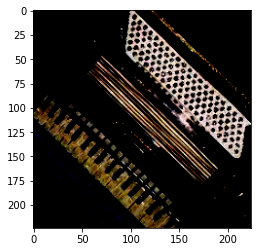

In [ ]:
#plot image HW
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.show()

In [ ]:
#plot image (deeplizard)
plt.imshow(image.squeeze(), cmap="gray")
torch.tensor(label)

#to show image of the data (youtube)
import matplotlib.pyplot as plt
plt.imshow(train_dataset[0][0].view(200,300))
plt.show()

In [ ]:
#accessing batch

display_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)
# note that each batch will be different when shuffle=True The shuffle functionality is turned off by default


batch = next(iter(display_loader))
print('len:', len(batch))

images, labels = batch
print('types:', type(images), type(labels))
print('images shape:', images.shape)#4D   but images[0].shape 3D
print('labels shape:', labels.shape)#1D of length=labels.shape

#show whole batch of images
grid=torchvision.utils.make_grid(images,nrow=10)
plt.figure()
plt.imshow(np.transpose(grid,(1,2,0))) #or plt.imshow(grid.permute(1,2,0))
print('labels:',labels)

len: 2
types: <class 'torch.Tensor'> <class 'torch.Tensor'>
images shape: torch.Size([10, 3, 224, 224])
labels shape: torch.Size([10])


In [ ]:
##another way to plot using DataLoader this time
#how_many_to_plot = 20
#train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)
#plt.figure(figsize=(50,50))
#for i, batch in enumerate(train_loader, start=1):
#    image, label = batch
#    plt.subplot(10,10,i)
#    plt.imshow(image.reshape(28,28), cmap='gray')
#    plt.axis('off')
#    plt.title(train_set.classes[label.item()], fontsize=28)
#    if (i >= how_many_to_plot): break
#plt.show()

# 2- common Randomsampler method



In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

valid_size = 0.33
shuffle= True
random_seed= 42


indices = list(range(len(train_dataset)))
split = int(np.floor(valid_size * len(train_dataset))) #number of validation samples

if shuffle:
   np.random.seed(random_seed)
   np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)



# 3- sklearn train-test-split

Divide Data into Train, Validation, and Test Set
We will divide our entire dataset into a training set, a validation set, and test data. The distribution is as such: 60% data for training, 20% data for validating, and 20% data for testing.

In [ ]:
(X, x_val , Y, y_val) = train_test_split(train_dataset, labels, 
                                                    test_size=0.2,  
                                                    stratify=labels,
                                                    random_state=42)
 
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, 
                                                    test_size=0.25, 
                                                    random_state=42)
 
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

#4- `RandomSplit`

In [ ]:
from torch.utils.data import random_split


train_size = int(0.67 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
#train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=4, drop_last=True)
#valid_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#ValueError: sampler option is mutually exclusive with shuffle 
#(corrected by removing shuffle in dataloader)
#does this mean i cant shuffle using this way? so it is disadvantage of it or it is because using sampler imply u already shuffled?

**Prepare Network**

In [ ]:
net = alexnet() # Loading AlexNet model
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

In [ ]:
#nice code
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'    

**Train**

In [ ]:
total_loss = 0
current_step = 0

criterion_val = nn.CrossEntropyLoss(reduction='sum')

net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime
batch_size_list = [100]
LR_list = [5e-3]


losses_train = []
losses_val = []
accuracies_val = []
accuracies_train = []


for BATCH_SIZE in batch_size_list:
    for LR in LR_list:
        #net = net
        #train_loader,val_loader = get_train_valid_loader(train_dataset,
        #                   BATCH_SIZE,  #                           augment,
        #                   valid_size=0.9,
        #                   shuffle=True,
        #                   show_sample=False,
        #                   num_workers=4,
        #                   pin_memory=False) #torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
                
        #Randomsampler
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler,num_workers=4, drop_last=True)
        valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=4)
       
        #RandomSplit
        #train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=4, drop_last=True)
        #valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

        optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
        for epoch in range(NUM_EPOCHS):
            total_loss = 0
            print('\n Starting epoch {}/{}, LR = {}, batch size= {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr(), BATCH_SIZE))
            for images, labels in train_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                net.train() #actually this is old latest pytorch versions net.zero_grad is enough instead of net.train()+optimizer.zero_grad() 
                optimizer.zero_grad() #1 # we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes
                outputs = net(images) #2
                loss = criterion(outputs, labels)  #3
                if (current_step % 30 == 0):
                    print('Step {}, Loss {}'.format(current_step, loss.item()))
                loss.backward()  #4 # backward pass: computes gradients
                optimizer.step() #5 # update weights based on accumulated gradients
                current_step += 1
                #total_loss += loss.item() * BATCH_SIZE
                #print('Loss', total_loss)
            
            net.train(False)
            running_corrects_val = 0
            cum_loss_val = 0

            #for images_val, labels_val in tqdm(val_dataloader):
            for images_val, labels_val in valid_loader:
                images_val = images_val.to(DEVICE)
                labels_val = labels_val.to(DEVICE)

                # Forward Pass
                outputs_val = net(images_val)

                cum_loss_val += criterion_val(outputs_val, labels_val).item()

                # Get predictions
                _, preds = torch.max(outputs_val.data, 1)

                # Update Corrects
                running_corrects_val += torch.sum(preds == labels_val.data).data.item() 

            accuracy_val = running_corrects_val / float(len(valid_dataset))
            loss_val = cum_loss_val / float(len(valid_dataset))

            losses_val.append(loss_val)
            accuracies_val.append(accuracy_val)
    
            print('Loss on val:', loss_val)
            print('Accuracy on val:', accuracy_val)    
            scheduler.step() #originally changes only every epoch not every image


 Starting epoch 1/30, LR = [0.005], batch size= 100


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 1.4885042905807495
Step 30, Loss 1.3003547191619873
Loss on val: 1.8275183797069967
Accuracy on val: 0.5615505500261917

 Starting epoch 2/30, LR = [0.005], batch size= 100
Step 60, Loss 1.4063780307769775
Loss on val: 1.8580271669430781
Accuracy on val: 0.5552645364064955

 Starting epoch 3/30, LR = [0.005], batch size= 100
Step 90, Loss 1.1622223854064941
Loss on val: 1.8321609586992458
Accuracy on val: 0.5610267155578837

 Starting epoch 4/30, LR = [0.005], batch size= 100
Step 120, Loss 1.1991392374038696
Step 150, Loss 1.2340301275253296
Loss on val: 1.8514293620197981
Accuracy on val: 0.5526453640649555

 Starting epoch 5/30, LR = [0.005], batch size= 100
Step 180, Loss 1.240157127380371
Loss on val: 1.8792727232104263
Accuracy on val: 0.5599790466212676

 Starting epoch 6/30, LR = [0.005], batch size= 100
Step 210, Loss 0.8128350973129272
Loss on val: 1.9143389356642133
Accuracy on val: 0.5646935568360398

 Starting epoch 7/30, LR = [0.005], batch size= 100
Step 240

**Test**

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [ ]:
#try this code for validation
correct=0
total=0

with torch.no_grad():
  for images, labels in train_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = net(images) #2
    for idx,i in enumerate(outputs):
      if torch.argmax(i) == labels[idx]:
        correct+=1
      total+=1

print("accuracy", round(correct/total,3))

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[0].view(28,28))
plt.show()

In [ ]:
print(torch.argmax(net(images[0].view(-1,784))[0])) #presdiction of first image

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 3/3 [00:10<00:00,  4.86s/it]

Test Accuracy: 0.09194607673695127
